In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

import warnings
warnings.filterwarnings("ignore")

In [3]:
covid = pd.read_parquet('covidClean.parquet')

df = covid.copy()

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
            "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
            "DEATH_DATE", "ORIGIN_COUNTRY", "AT_RISK"]
df = df.drop(columns = toRemove)

----
## IQR (Scarto interquartile) OUTLINER DETECTION

<Axes: >

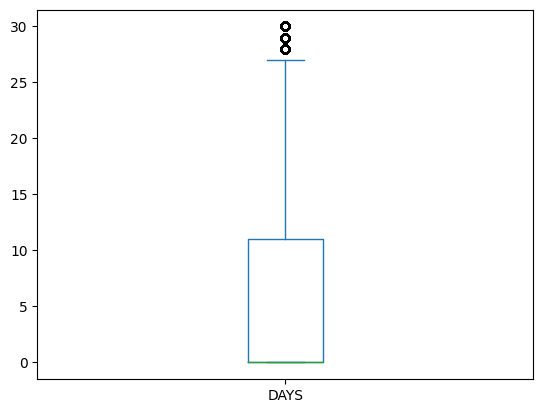

In [4]:
df.DAYS.plot(kind="box")

In [5]:
q25, q75 = np.percentile(df["DAYS"], [25, 75])
iqr = q75 - q25


# df = df[(df["DAYS"] >= q25 - 1.5 * iqr) & (df["DAYS"] <= q75 + 1.5 * iqr)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596278 entries, 15 to 4075326
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEX             596278 non-null  bool   
 1   INTUBED         596278 non-null  bool   
 2   PNEUMONIA       596278 non-null  bool   
 3   AGE             596278 non-null  int64  
 4   PREGNANT        596278 non-null  bool   
 5   DIABETES        596278 non-null  bool   
 6   COPD            596278 non-null  bool   
 7   ASTHMA          596278 non-null  bool   
 8   INMUSUPR        596278 non-null  bool   
 9   HYPERTENSION    596278 non-null  bool   
 10  OTHER_DISEASE   596278 non-null  bool   
 11  CARDIOVASCULAR  596278 non-null  bool   
 12  OBESITY         596278 non-null  bool   
 13  RENAL_CHRONIC   596278 non-null  bool   
 14  TOBACCO         596278 non-null  bool   
 15  ICU             596278 non-null  bool   
 16  DIED            596278 non-null  bool   
 17  DAYS    

<Axes: >

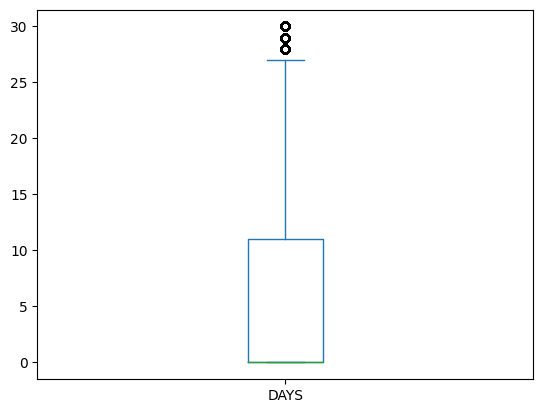

In [6]:
df.DAYS.plot(kind="box")

----

<Axes: ylabel='Density'>

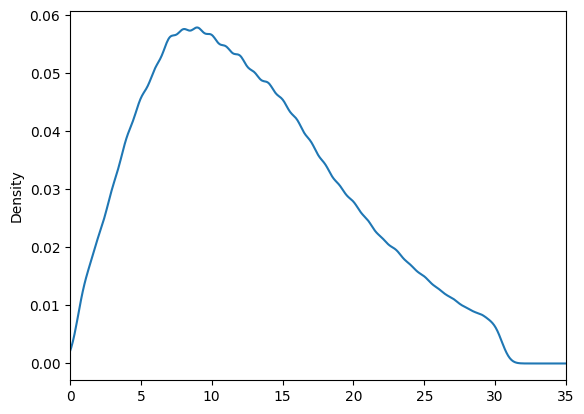

In [7]:
df.DAYS[df.DAYS != 0].plot(kind="kde", xlim=(0, 35))

In [8]:

def getPValues(df):
    res = {}
    columns = [x for x in df.columns if x != "DAYS" and x != "DIED"]
    for col in columns:
        res[col] = pairwise_logrank_test(df["DAYS"], df[col], df["DIED"]).p_value[0]
    return res

------------

In [9]:
import weightedstats as ws

ages = df.copy()
medianAge = ws.numpy_weighted_median(ages["AGE"], ages["AGE"].value_counts())
ages.AGE = ages.AGE >= medianAge
medianAge

49

In [10]:
pValues = sorted(getPValues(ages).items(), key=lambda x: x[1])
pValues

[('INTUBED', 0.0),
 ('RENAL_CHRONIC', 0.0),
 ('ICU', 0.0),
 ('DIABETES', 1.969999737420521e-162),
 ('PNEUMONIA', 4.060346433131771e-68),
 ('HYPERTENSION', 9.972417579384005e-49),
 ('COPD', 2.3395414222754644e-35),
 ('CARDIOVASCULAR', 1.0500527472287335e-33),
 ('SEX', 7.7632508582167e-28),
 ('INMUSUPR', 1.972787771778073e-12),
 ('TOBACCO', 5.693326807703877e-12),
 ('OBESITY', 8.384186893401736e-12),
 ('PREGNANT', 2.464904365667908e-10),
 ('AGE', 3.4393516066117785e-08),
 ('ASTHMA', 0.00025083142520305476),
 ('OTHER_DISEASE', 0.012777992994615775)]

In [11]:
def printGraph(df, colname, legend = ["NO", "YES"]):
    for elem in set(df[colname]):
        indexis = df[df[colname] == elem]
        
        kmf = KaplanMeierFitter()
        kmf.fit(indexis["DAYS"], indexis["DIED"])
        kmf.plot(label = legend[elem], show_censors=True)
        
        pValue = pairwise_logrank_test(df["DAYS"], df[colname], df["DIED"]).p_value[0]
        plt.text(0.1, 0.1, "p-value: " + str(pValue), fontsize=9)
        plt.grid(True)
        plt.title(colname)
        
        medianSurvTime = int(kmf.median_survival_time_)

TypeError: 'float' object cannot be interpreted as an integer

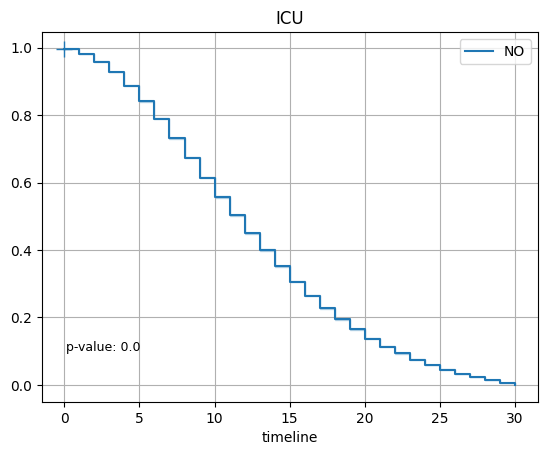

In [12]:
printGraph(ages, "ICU")
plt.show()

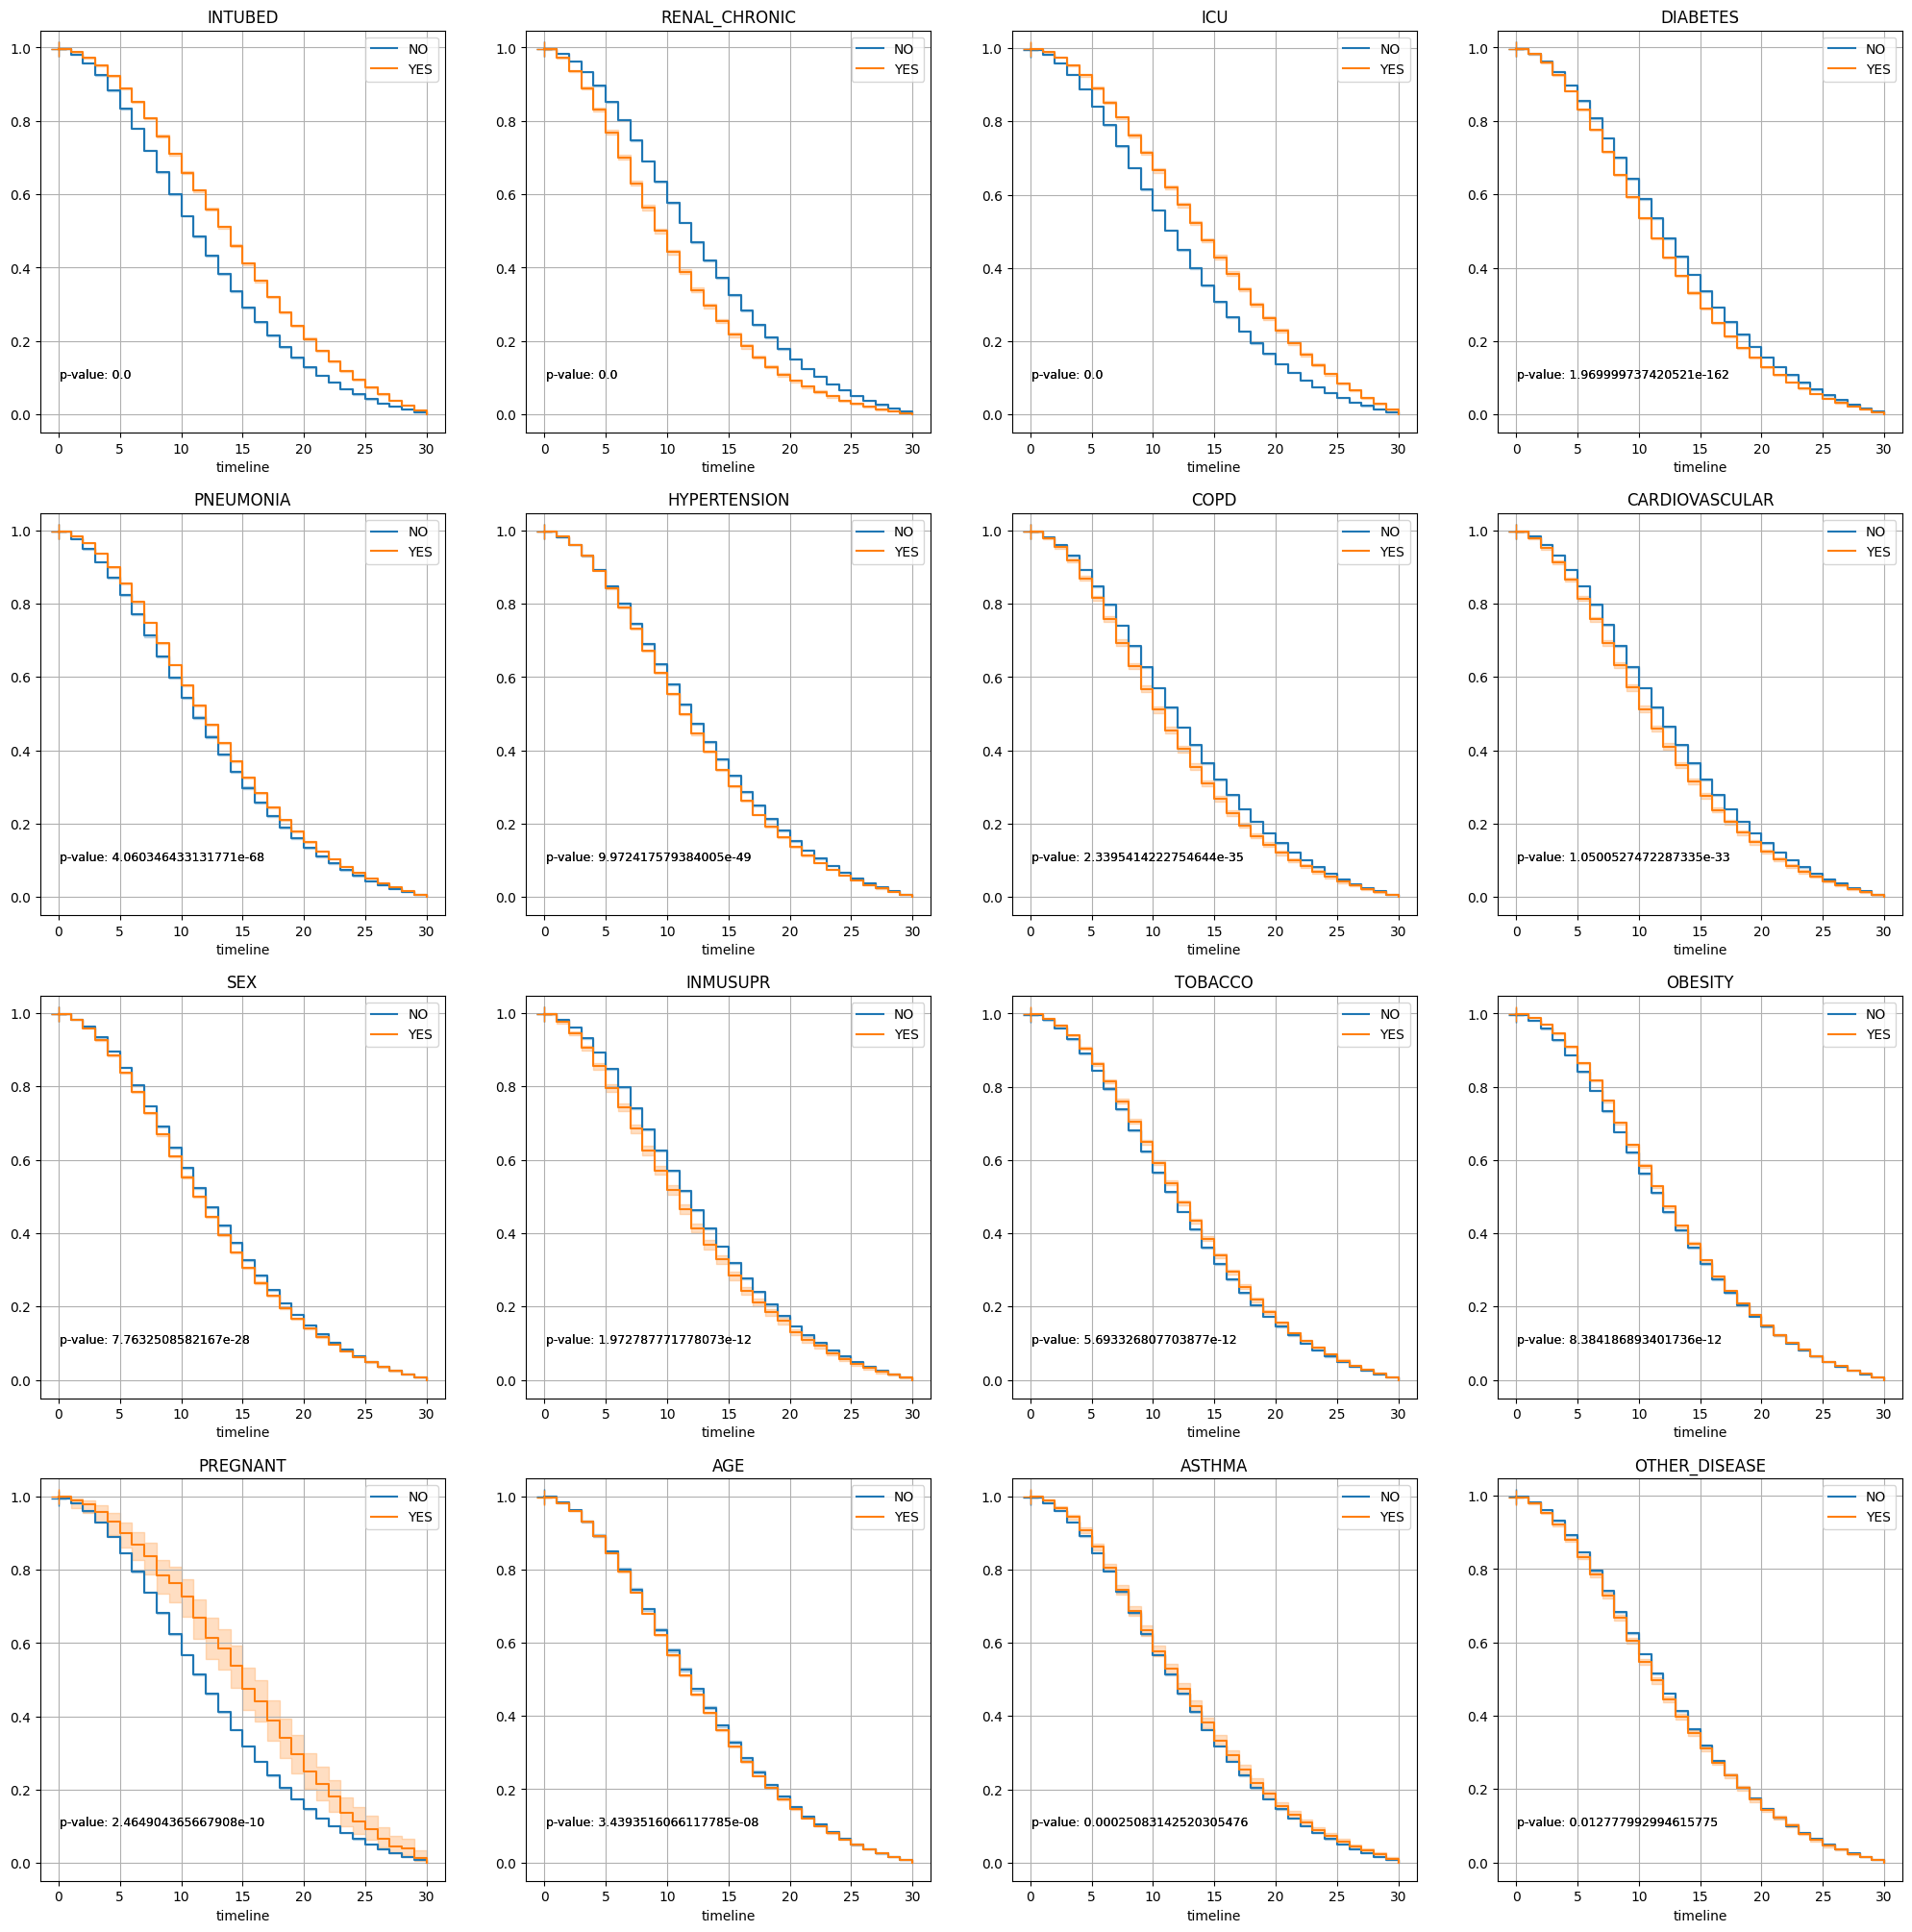

In [ ]:
plt.figure(figsize=(25, 25))
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, i * 4 + j + 1)
        printGraph(ages, pValues[i * 4 + j][0])
plt.show()